## Стратегия возврата к среднему значению (Mean reversion) использую полосы Боллинджера (Bollinger Bands)
Торговля по принципу средней реверсии предполагает, что цены вернутся к среднему значению. Таким образом, всякий раз, когда цены слишком далеки от среднего значения, мы будем занимать позицию (длинную или короткую) и закрывать позицию, когда цена возвращается к среднему значению.
Полосами Боллинджера называются следующие триобъекта: центральная полоса - это скользящее среднее за несколько последних торговых дней. Верхняя полоса - это сумма стандартного отклонения за несколько последних торговых дней,домноженногона коэффициент, который определяется заранее, и средней полосы. Нижняя полоса, соответственно получается за счёт вычитания из средней полосы стандартного отклонения за несколько последних торговых
дней, домноженное на коэффициент. Как правило коэффициенты для верхней и нижней полосы совпадают. 
В приведенном ниже примере Стратегия восстановления реализуется на валютной паре EURCHF (Евро - Швейцарский Франк).

### Загружаем необходимые библиотеки

In [34]:
import pandas as pd
import pandas_datareader as dr
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from numpy.linalg import inv
from statsmodels.api import OLS
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr
# To perform ADF Test
from statsmodels.tsa.stattools import adfuller

### Сырые финансовые данные, которые мы используем находятся в формате csv файла
Для того, чтобы прочатать эти данные в питоне используется команда "pandas.read_csv()".

Syntax: pd.read_csv(filename)
filename: Name of the file in the string format

Поскольку не всегда данные расположены в хронологическом порядке, то их необходимо правильно отсортировать, следующая команда делает сортировку по дате

In [35]:
df = dr.get_data_yahoo("CBOM.ME")

In [36]:
df.sort_values(by=['Date'], inplace=True)

In [37]:
df.rename(columns={"Adj Close":"Price"}, inplace=True)

In [38]:
df.head()

,High,Low,Open,Close,Volume,Price
Date,,,,,,
2015-07-01,3.70647,3.59151,3.59448,3.64700,22199552.0,3.579847
2015-07-02,3.76593,3.59151,3.76593,3.61281,27957072.0,3.546287
2015-07-03,3.69160,3.59894,3.69160,3.60439,38557012.0,3.538022
2015-07-06,3.63709,3.60736,3.60786,3.63709,8483465.0,3.570120
2015-07-07,3.76593,3.59844,3.76593,3.59844,30759598.0,3.532182


Визуализация временного ряда

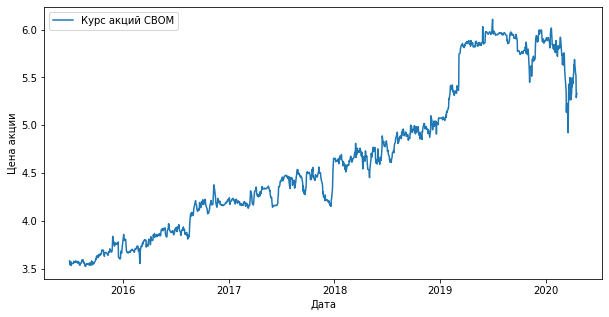

In [39]:
plt.figure(figsize=(10,5))
plt.plot(df.Price, label='Курс акций CBOM')

plt.xlabel('Дата')  
plt.ylabel('Цена акции')  
plt.legend()  

plt.show()

### Скользящее среднее и скользящее стандартное отклонение
Скользящее среднее вычисляется с использованием библиотеки pandas с помощью функции rolling().mean():

### DataFrame.column_name.rolling(lookback_period).mean()
Скользящее стандартное отклонение вычисляется с использованием библиотеки pandas с помощью функции rolling().std() function as shown below:

Синтаксис:
DataFrame.column_name.rolling(lookback_period).std()

In [40]:
# Период, за который рассматривается скользящее значение
lookback=5
# Скользящее среднее
df['moving_average'] = df['Price'].rolling(lookback).mean()

# Скользящее стандартное отклонение
df['moving_std_dev'] = df['Price'].rolling(lookback).std()
df.head(7)

,High,Low,Open,Close,Volume,Price,moving_average,moving_std_dev
Date,,,,,,,,
2015-07-01,3.70647,3.59151,3.59448,3.64700,22199552.0,3.579847,NaN,NaN
2015-07-02,3.76593,3.59151,3.76593,3.61281,27957072.0,3.546287,NaN,NaN
2015-07-03,3.69160,3.59894,3.69160,3.60439,38557012.0,3.538022,NaN,NaN
2015-07-06,3.63709,3.60736,3.60786,3.63709,8483465.0,3.570120,NaN,NaN
2015-07-07,3.76593,3.59844,3.76593,3.59844,30759598.0,3.532182,3.553291,0.020714
2015-07-08,3.62718,3.58804,3.58804,3.61628,40767635.0,3.549693,3.547261,0.014510
2015-07-09,3.61727,3.59250,3.59250,3.61727,34994167.0,3.550665,3.548136,0.014568


Удалим лишние столбцы для удобства

In [41]:
df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

In [42]:
df.head(7)

,Price,moving_average,moving_std_dev
Date,,,
2015-07-01,3.579847,NaN,NaN
2015-07-02,3.546287,NaN,NaN
2015-07-03,3.538022,NaN,NaN
2015-07-06,3.570120,NaN,NaN
2015-07-07,3.532182,3.553291,0.020714
2015-07-08,3.549693,3.547261,0.014510
2015-07-09,3.550665,3.548136,0.014568


### Верхняя линия Боллинджера (Upper band) и нижняя линяя Боллинджера (lower band)
Верхняя линия - это сумма половины (пологаем, что коэффициент 0.5) стандартного отклонения и скользящего среднего,аналогично нижняя линия получается путём вычитания из скользящего среднего половины скользящего стандартного отклонения.

In [43]:
df['upper_band'] = df.moving_average + 0.5*df.moving_std_dev
df['lower_band'] = df.moving_average - 0.5*df.moving_std_dev

### Открытие позициина покупку (Long entry) и закрытие позиции на покупку (long exit)
Колонка Long_entry содержит значение True, если цена находится ниже нижней линии Боллинджера и значение False иначе.

Колонка Long_exit содержит значение True, если цена вернулась к скользящему среднему значению, то есть сравнялась с ним или превысила (Price >= moving average) и значение False иначе.

In [44]:
df['long_entry'] = df.Price < df.lower_band   
df['long_exit'] = df.Price >= df.moving_average
df.head(7)

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit
Date,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True


### Открытие короткой позиции (Short entry) и закрытие короткой позиции (short exit)
В колонке Short entry находится значение True, если цена превысила верхнюю полосу Боллинджера и значение False иначе.

В колонке Short exit расположим значение True, если цена вернулась к своему скользящему среднему, то есть выполнилось условие (Price <= moving average) и значение False иначе.

In [45]:
df['short_entry'] = df.Price > df.upper_band   
df['short_exit'] = df.Price <= df.moving_average
df.head(7)

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit
Date,,,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False,False,False
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False,False,False
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False,False,False
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False,False,False
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False,False,True
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True,False,False
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True,False,False


### Длинные позиции (Long positions) и короткие позиции (short positions)
Столбцы длинных и коротких позиций (positions_long, positions_short) начинаются со значений NaN (инициализация). 
1 соответствуют открытой длинной позиции (в столбце long_entry значение True), в столбце Диинная позиция (positions_long). 0 в столбце длинной позиции, если в столбце закрытия длинной позиции (long_exit) находится True.
Аналогичным образом, -1 и 0 в столбце короткой позиции (positions_short).

In [46]:
df['positions_long'] = np.nan  
df.loc[df.long_entry,'positions_long']= 1  
df.loc[df.long_exit,'positions_long']= 0  
  
df['positions_short'] = np.nan  
df.loc[df.short_entry,'positions_short']= -1  
df.loc[df.short_exit,'positions_short']= 0  

df.head(7)

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short
Date,,,,,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False,False,True,1.0,0.0
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True,False,False,0.0,NaN
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True,False,False,0.0,NaN


### Устраним NaN значения
DataFrame.fillna() - специальная функция, которая позволяет справиться с этой задачей method = 'ffill'.

In [47]:
df = df.fillna(method='ffill')  
df.head(7)

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short
Date,,,,,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False,False,True,1.0,0.0
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True,False,False,0.0,0.0
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True,False,False,0.0,0.0


### добавим столбец Позиции (Positions)
Мы получили столбец Позиции с помощью соединения столбцов positions_long и positions_short.

In [48]:
df['positions'] = df.positions_long + df.positions_short

### Накопленная прибыль (PnL)
PnL вычисляется путём умножения позиции предыдущего дня (long or short) на текущую дневную доходность, накопленный PnL вычисляется с помощью функции cumsum().

In [49]:
#pnl на единицу капитала - это просто дневная прибыль
df['prices_difference']= df.Price - df.Price.shift(1)
df['daily_returns'] = df.prices_difference /df.Price.shift(1)
df['pnl'] = df.positions.shift(1) * df.daily_returns
df['cumpnl'] = df.pnl.cumsum()

### График прибыли (PnL)

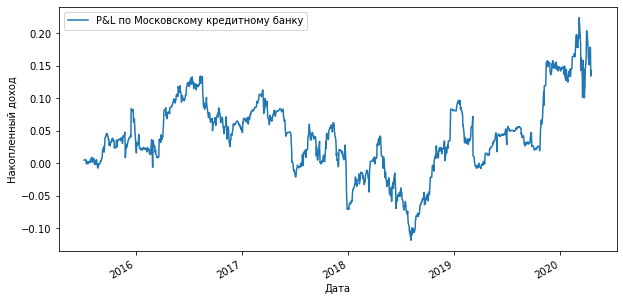

In [50]:
df.cumpnl.plot(label='P&L по Московскому кредитному банку', figsize=(10,5))  
plt.xlabel('Дата')  
plt.ylabel('Накопленный доход')  
plt.legend()  
plt.show()

In [90]:
df['coef_pnl'] = df.pnl + 1
df['cumpnl_prod'] = df.coef_pnl.cumprod()

In [91]:
df

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short,positions,prices_difference,daily_returns,pnl,cumpnl,cumpnl_prod,coef_pnl
Date,,,,,,,,,,,,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.033561,-0.009375,NaN,NaN,NaN,NaN
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.008265,-0.002331,NaN,NaN,NaN,NaN
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,0.032098,0.009072,NaN,NaN,NaN,NaN
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False,False,True,1.0,0.0,1.0,-0.037938,-0.010627,NaN,NaN,NaN,NaN
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True,False,False,0.0,0.0,0.0,0.017512,0.004958,0.004958,0.004958,1.004958,1.004958
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True,False,False,0.0,0.0,0.0,0.000972,0.000274,0.000000,0.004958,1.004958,1.000000
2015-07-10,3.550665,3.550665,0.013426,3.557378,3.543952,False,False,False,True,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004958,1.004958,1.000000
2015-07-13,3.555043,3.547649,0.008892,3.552095,3.543203,False,True,True,False,0.0,-1.0,-1.0,0.004378,0.001233,0.000000,0.004958,1.004958,1.000000


In [52]:
mean_reversion_results = df.describe()

In [62]:
mean_reversion_results.iloc[2,10]

0.008449778310649832

P&L = 14.27%

annual return

In [55]:
round(0.142701/1207*365*100,2)

4.32

Sharpe ratio

In [65]:
(0.142701/1207*365-0.04)/(mean_reversion_results.iloc[2,10])**0.5

0.03430231664326409

In [66]:
df

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short,positions,prices_difference,daily_returns,pnl,cumpnl
Date,,,,,,,,,,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.033561,-0.009375,NaN,NaN
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.008265,-0.002331,NaN,NaN
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,0.032098,0.009072,NaN,NaN
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False,False,True,1.0,0.0,1.0,-0.037938,-0.010627,NaN,NaN
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True,False,False,0.0,0.0,0.0,0.017512,0.004958,0.004958,0.004958
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True,False,False,0.0,0.0,0.0,0.000972,0.000274,0.000000,0.004958
2015-07-10,3.550665,3.550665,0.013426,3.557378,3.543952,False,False,False,True,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004958
2015-07-13,3.555043,3.547649,0.008892,3.552095,3.543203,False,True,True,False,0.0,-1.0,-1.0,0.004378,0.001233,0.000000,0.004958


In [82]:
df


,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short,positions,prices_difference,daily_returns,pnl,cumpnl
Date,,,,,,,,,,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.033561,-0.009375,NaN,NaN
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.008265,-0.002331,NaN,NaN
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,0.032098,0.009072,NaN,NaN
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False,False,True,1.0,0.0,1.0,-0.037938,-0.010627,NaN,NaN
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True,False,False,0.0,0.0,0.0,0.017512,0.004958,0.004958,0.004958
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True,False,False,0.0,0.0,0.0,0.000972,0.000274,0.000000,0.004958
2015-07-10,3.550665,3.550665,0.013426,3.557378,3.543952,False,False,False,True,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004958
2015-07-13,3.555043,3.547649,0.008892,3.552095,3.543203,False,True,True,False,0.0,-1.0,-1.0,0.004378,0.001233,0.000000,0.004958


Start date,2015-07-08
End date,2020-04-17
Total months,57
,Backtest
Annual return,2.1%
Cumulative returns,10.5%
Annual volatility,13.4%
Sharpe ratio,0.22
Calmar ratio,0.09
Stability,0.01
Max drawdown,-23.4%


C:\Users\2\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.44,2016-08-11,2018-08-06,2020-02-12,915
1,12.15,2020-03-06,2020-03-24,NaT,NaN
2,8.82,2015-12-18,2016-02-29,2016-05-05,100
3,3.87,2015-11-25,2015-11-27,2015-12-17,17
4,2.50,2016-06-02,2016-06-07,2016-06-27,18


Stress Events,mean,min,max
Fall2015,0.10%,-0.82%,0.96%
New Normal,0.01%,-6.09%,5.71%


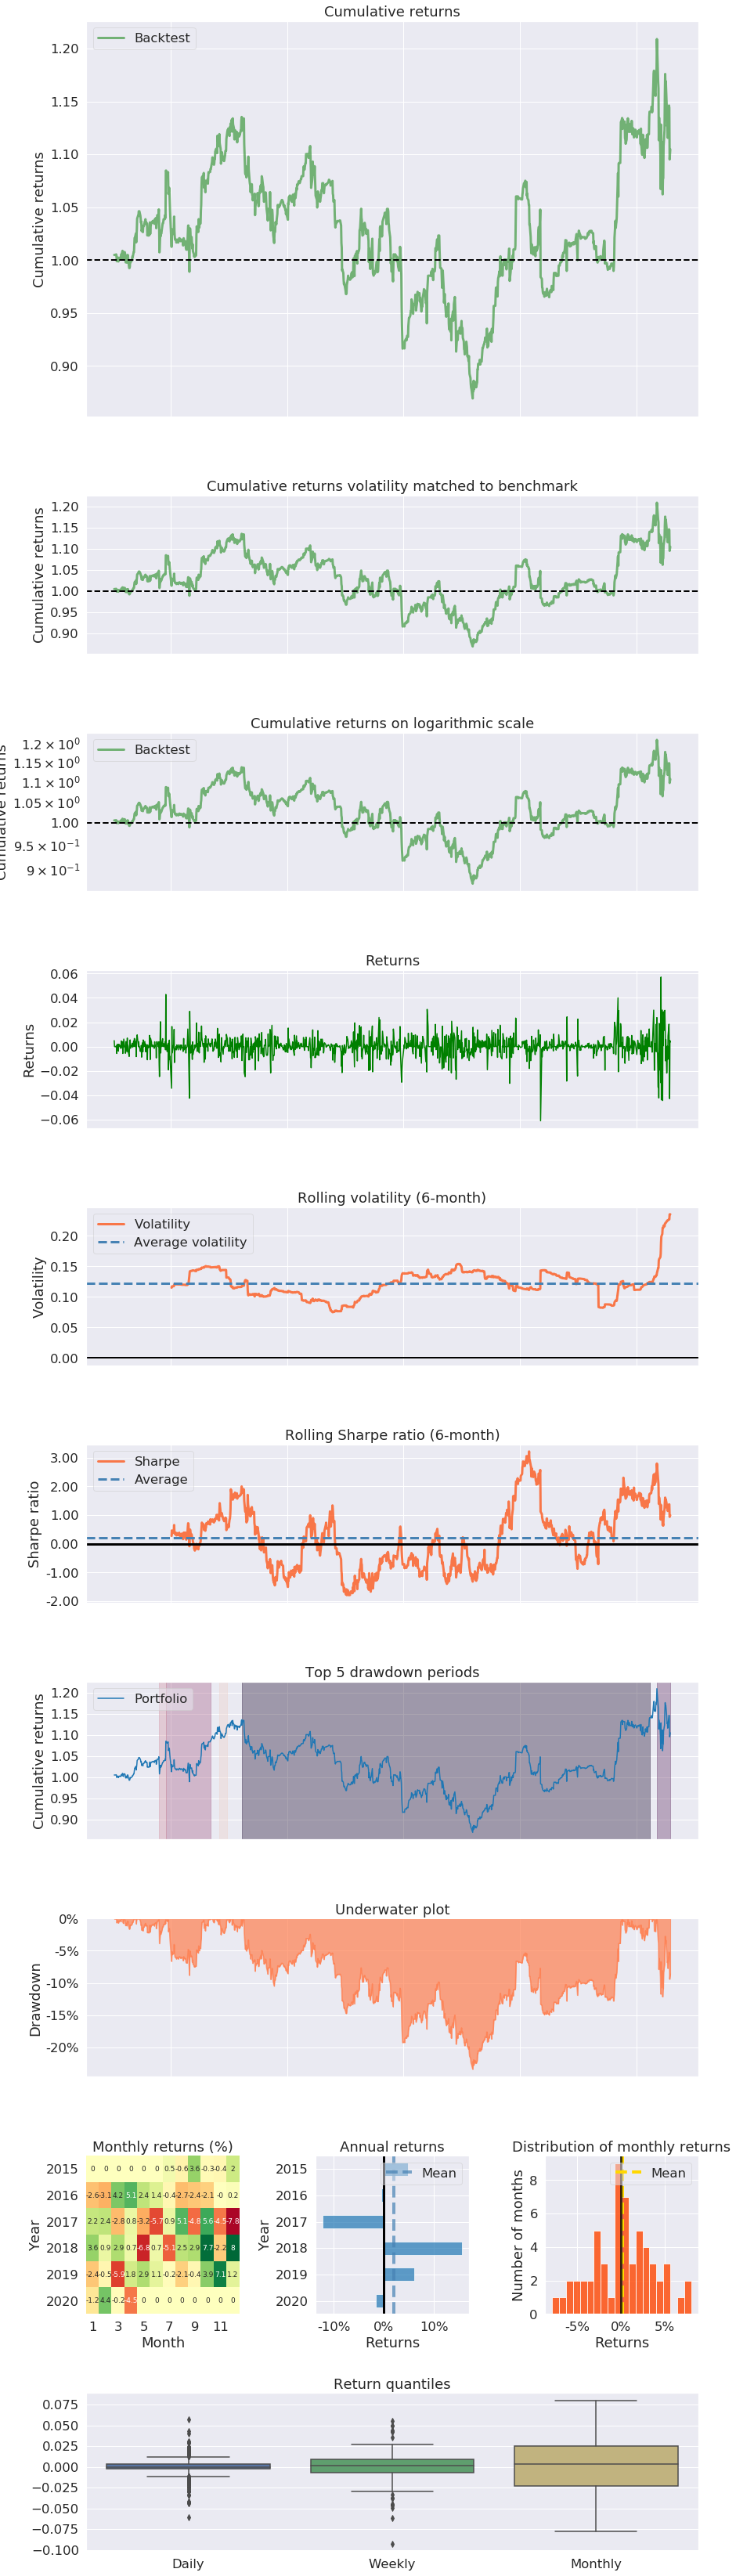

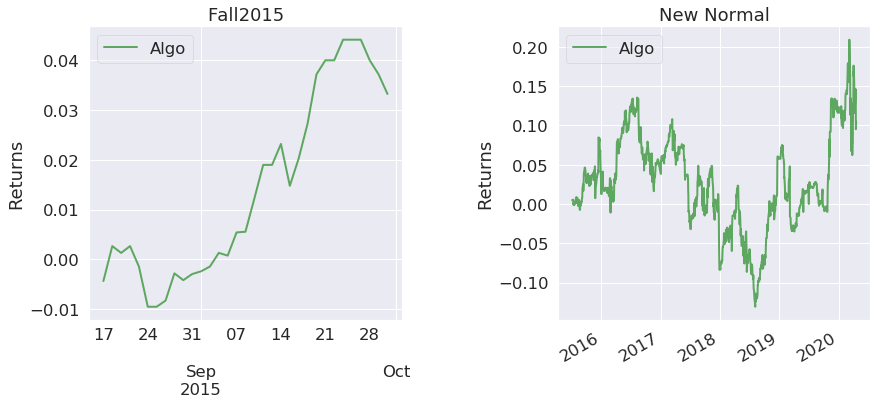

In [80]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))


In [77]:
portfolio = pd.DataFrame(df["pnl"])

In [78]:
portfolio.dropna(inplace=True)